## 读取数据

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.metrics import roc_auc_score

import lightgbm as lgb

from tqdm import tqdm

In [2]:
trainData = pd.read_csv('./data/train_set.csv')
testData  = pd.read_csv('./data/test_set.csv')
trainDataLen = len(trainData)
testDataLen = len(testData)
allData = pd.concat([trainData, testData], sort = False)

In [3]:
# 查看数据信息
allData.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,1,43,management,married,tertiary,no,291,yes,no,unknown,9,may,150,2,-1,0,unknown,0.0
1,2,42,technician,divorced,primary,no,5076,yes,no,cellular,7,apr,99,1,251,2,other,0.0
2,3,47,admin.,married,secondary,no,104,yes,yes,cellular,14,jul,77,2,-1,0,unknown,0.0
3,4,28,management,single,secondary,no,-994,yes,yes,cellular,18,jul,174,2,-1,0,unknown,0.0
4,5,42,technician,divorced,secondary,no,2974,yes,no,unknown,21,may,187,5,-1,0,unknown,0.0


In [4]:
allData.describe()

,ID,age,balance,day,duration,campaign,pdays,previous,y
count,36169.00000,36169.000000,36169.000000,36169.000000,36169.000000,36169.000000,36169.000000,36169.000000,25317.000000
mean,18085.00000,40.966961,1368.237026,15.788742,257.574497,2.771545,40.160552,0.578147,0.116957
std,10441.23528,10.639679,3098.876172,8.314523,255.040668,3.114445,100.005886,2.365582,0.321375
min,1.00000,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,9043.00000,33.000000,73.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,18085.00000,39.000000,449.000000,16.000000,181.000000,2.000000,-1.000000,0.000000,0.000000
75%,27127.00000,48.000000,1437.000000,21.000000,318.000000,3.000000,-1.000000,0.000000,0.000000
max,36169.00000,95.000000,102127.000000,31.000000,3881.000000,58.000000,871.000000,275.000000,1.000000


In [5]:
# 查看所有object的枚举类型
# 帅选出object类型
def objectInfoView(data):
    columnObjects = data.columns[data.dtypes=="object"]
    dic = {}
    for object in columnObjects:
        dic[object] = data[object].unique()
    return dic

In [6]:
objectInfoView(allData)

{'job': array(['management', 'technician', 'admin.', 'services', 'retired',
        'student', 'blue-collar', 'unknown', 'entrepreneur', 'housemaid',
        'self-employed', 'unemployed'], dtype=object),
 'marital': array(['married', 'divorced', 'single'], dtype=object),
 'education': array(['tertiary', 'primary', 'secondary', 'unknown'], dtype=object),
 'default': array(['no', 'yes'], dtype=object),
 'housing': array(['yes', 'no'], dtype=object),
 'loan': array(['no', 'yes'], dtype=object),
 'contact': array(['unknown', 'cellular', 'telephone'], dtype=object),
 'month': array(['may', 'apr', 'jul', 'jun', 'nov', 'aug', 'jan', 'feb', 'dec',
        'oct', 'sep', 'mar'], dtype=object),
 'poutcome': array(['unknown', 'other', 'failure', 'success'], dtype=object)}

In [7]:
allData.groupby('campaign').size().reset_index().rename(columns={0:'campaign'})
#allData.merge()

,campaign,campaign
0,1,14032
1,2,9989
2,3,4427
3,4,2829
4,5,1391
5,6,1036
6,7,580
7,8,421
8,9,268
9,10,217


In [8]:
def feature_count(data, features):
    feature_name = 'count'
    for i in features:
        feature_name += '_' + i
    temp = data.groupby(features).size().reset_index().rename(columns={0: feature_name})
    data = data.merge(temp, 'left', on=features)
    return data,feature_name

In [9]:
feature=allData.columns.tolist()
feature.remove('ID')
feature.remove('y')
sparse_feature= ['campaign','contact','default','education','housing','job','loan','marital','month','poutcome']
dense_feature=list(set(feature)-set(sparse_feature))

In [10]:
ll=[]
for f in['campaign', 'contact','default','education','housing','job','loan','marital','poutcome']:
    allData,_=feature_count(allData,['day','month',f])
    ll.append(_)
print(ll)
allData.head()

['count_day_month_campaign', 'count_day_month_contact', 'count_day_month_default', 'count_day_month_education', 'count_day_month_housing', 'count_day_month_job', 'count_day_month_loan', 'count_day_month_marital', 'count_day_month_poutcome']


,ID,age,job,marital,education,default,balance,housing,loan,contact,...,y,count_day_month_campaign,count_day_month_contact,count_day_month_default,count_day_month_education,count_day_month_housing,count_day_month_job,count_day_month_loan,count_day_month_marital,count_day_month_poutcome
0,1,43,management,married,tertiary,no,291,yes,no,unknown,...,0.0,112,338,326,67,303,46,292,180,338
1,2,42,technician,divorced,primary,no,5076,yes,no,cellular,...,0.0,41,68,71,9,54,12,62,9,7
2,3,47,admin.,married,secondary,no,104,yes,yes,cellular,...,0.0,78,204,230,147,138,30,64,166,235
3,4,28,management,single,secondary,no,-994,yes,yes,cellular,...,0.0,49,194,194,110,130,60,72,53,206
4,5,42,technician,divorced,secondary,no,2974,yes,no,unknown,...,0.0,15,357,361,213,326,63,313,24,358


In [11]:
def get_new_columns(name,aggs):
    l=[]
    for k in aggs.keys():
        for agg in aggs[k]:
            if str(type(agg))=="<class 'function'>":
                l.append(name + '_' + k + '_' + 'other')
            else:
                l.append(name + '_' + k + '_' + agg)
    return l

In [12]:
for d in tqdm(sparse_feature):
    aggs={}
    for s in sparse_feature:
        aggs[s]=['count','nunique']
    for den in dense_feature:
        aggs[den]=['mean','max','min','std']
    aggs.pop(d)
    temp=allData.groupby(d).agg(aggs).reset_index()
    temp.columns=[d]+get_new_columns(d,aggs)
    allData=pd.merge(allData,temp,on=d,how='left')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  3.87s/it]


In [13]:
allData.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,...,poutcome_day_min,poutcome_day_std,poutcome_age_mean,poutcome_age_max,poutcome_age_min,poutcome_age_std,poutcome_pdays_mean,poutcome_pdays_max,poutcome_pdays_min,poutcome_pdays_std
0,1,43,management,married,tertiary,no,291,yes,no,unknown,...,1,8.370244,40.958787,95,18,10.448508,-0.952528,528,-1,4.225828
1,2,42,technician,divorced,primary,no,5076,yes,no,cellular,...,1,8.145426,39.932881,89,18,11.297997,226.557966,838,1,123.825801
2,3,47,admin.,married,secondary,no,104,yes,yes,cellular,...,1,8.370244,40.958787,95,18,10.448508,-0.952528,528,-1,4.225828
3,4,28,management,single,secondary,no,-994,yes,yes,cellular,...,1,8.370244,40.958787,95,18,10.448508,-0.952528,528,-1,4.225828
4,5,42,technician,divorced,secondary,no,2974,yes,no,unknown,...,1,8.370244,40.958787,95,18,10.448508,-0.952528,528,-1,4.225828


## 数据预处理

| NO |  字段名称 | 数据类型 |                             字段描述                            |
|:--:|:---------:|:--------:|:---------------------------------------------------------------:|
|  1 |     ID    |    Int   |                           客户唯一标识                          |
|  2 |    age    |    Int   |                             客户年龄                            |
|  3 |    job    |  String  |                            客户的职业                           |
|  4 |  marital  |  String  |                             婚姻状况                            |
|  5 | education |  String  |                            受教育水平                           |
|  6 |  default  |  String  |                          是否有违约记录                         |
|  7 |  balance  |    Int   |                        每年账户的平均余额                       |
|  8 |  housing  |  String  |                          是否有住房贷款                         |
|  9 |    loan   |  String  |                          是否有个人贷款                         |
| 10 |  contact  |  String  |                       与客户联系的沟通方式                      |
| 11 |    day    |    Int   |                    最后一次联系的时间（几号）                   |
| 12 |   month   |  String  |                    最后一次联系的时间（月份）                   |
| 13 |  duration |    Int   |                      最后一次联系的交流时长                     |
| 14 |  campaign |    Int   |                在本次活动中，与该客户交流过的次数               |
| 15 |   pdays   |    Int   | 距离上次活动最后一次联系该客户，过去了多久（999表示没有联系过） |
| 16 |  previous |    Int   |               在本次活动之前，与该客户交流过的次数              |
| 17 |  poutcome |  String  |                         上一次活动的结果                        |
| 18 |     y     |    Int   |                  预测客户是否会订购定期存款业务                 |

### 对文本类型数据进行编码

In [14]:
# 对文本数据进行编码
for col in allData.columns[allData.dtypes=='object']:
    le = LabelEncoder()
    le.fit(allData[col])
    
    allData[col] = le.transform(allData[col])

allData.head()


,ID,age,job,marital,education,default,balance,housing,loan,contact,...,poutcome_day_min,poutcome_day_std,poutcome_age_mean,poutcome_age_max,poutcome_age_min,poutcome_age_std,poutcome_pdays_mean,poutcome_pdays_max,poutcome_pdays_min,poutcome_pdays_std
0,1,43,4,1,2,0,291,1,0,2,...,1,8.370244,40.958787,95,18,10.448508,-0.952528,528,-1,4.225828
1,2,42,9,0,0,0,5076,1,0,0,...,1,8.145426,39.932881,89,18,11.297997,226.557966,838,1,123.825801
2,3,47,0,1,1,0,104,1,1,0,...,1,8.370244,40.958787,95,18,10.448508,-0.952528,528,-1,4.225828
3,4,28,4,2,1,0,-994,1,1,0,...,1,8.370244,40.958787,95,18,10.448508,-0.952528,528,-1,4.225828
4,5,42,9,0,1,0,2974,1,0,2,...,1,8.370244,40.958787,95,18,10.448508,-0.952528,528,-1,4.225828


## 划分数据集

In [15]:
train_use_col = list(set(allData.columns)-set(['ID','y']))


delElements = allData.columns[allData.isna().any()].tolist()
print(delElements)
for ele in delElements:
    if ele in train_use_col:
        train_use_col.remove(ele)

X1 = allData[train_use_col][:trainDataLen]
y1 = allData['y'][:trainDataLen]

X2 = allData[trainDataLen:][train_use_col]
X1.head()

['y', 'campaign_balance_std', 'campaign_duration_std', 'campaign_previous_std', 'campaign_day_std', 'campaign_age_std', 'campaign_pdays_std']


,month_balance_max,job_housing_nunique,job_balance_max,contact_balance_mean,contact_month_nunique,education_age_max,loan_day_min,loan_marital_count,marital_pdays_min,job_age_max,...,housing_campaign_count,housing_default_count,loan_default_nunique,campaign_month_count,contact_loan_nunique,poutcome_default_count,contact_poutcome_count,education_balance_std,education_previous_mean,housing_age_std
0,58544,2,102127,1189.923602,12,89,1,30363,-1,81,...,19959,19959,2,9989,2,29554,10393,3882.583138,0.658344,8.931403
1,81204,2,45248,1400.778726,12,95,1,30363,-1,71,...,19959,19959,2,14032,2,1475,23437,2780.466021,0.491353,8.931403
2,58932,2,64343,1400.778726,12,95,1,5806,-1,75,...,19959,19959,2,9989,2,29554,23437,2600.229372,0.565293,8.931403
3,58932,2,102127,1400.778726,12,95,1,5806,-1,81,...,19959,19959,2,9989,2,29554,23437,2600.229372,0.565293,8.931403
4,58544,2,45248,1189.923602,12,95,1,30363,-1,71,...,19959,19959,2,1391,2,29554,10393,2600.229372,0.565293,8.931403


## 特征选择

In [16]:
# Univariate Selection
'''
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X1,y1)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X1.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features
'''

"\nbestfeatures = SelectKBest(score_func=chi2, k=10)\nfit = bestfeatures.fit(X1,y1)\ndfscores = pd.DataFrame(fit.scores_)\ndfcolumns = pd.DataFrame(X1.columns)\n#concat two dataframes for better visualization \nfeatureScores = pd.concat([dfcolumns,dfscores],axis=1)\nfeatureScores.columns = ['Specs','Score']  #naming the dataframe columns\nprint(featureScores.nlargest(10,'Score'))  #print 10 best features\n"

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


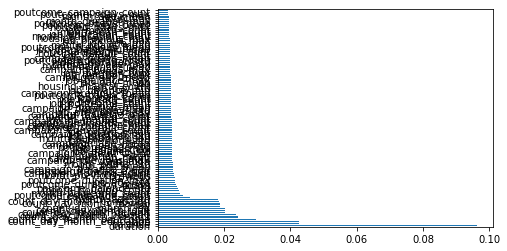

In [17]:
# Feature Importance
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X1[train_use_col],y1)
#print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=train_use_col)
feat_importances.nlargest(100).plot(kind='barh')
plt.show()

In [18]:
'''
# Correlation Matrix with Heatmap
import seaborn as sns

corrData = X1[train_use_col]
corrmat = corrData.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrData[top_corr_features].corr(),annot=True,cmap="RdYlGn")
'''

'\n# Correlation Matrix with Heatmap\nimport seaborn as sns\n\ncorrData = X1[train_use_col]\ncorrmat = corrData.corr()\ntop_corr_features = corrmat.index\nplt.figure(figsize=(20,20))\n#plot heat map\ng=sns.heatmap(corrData[top_corr_features].corr(),annot=True,cmap="RdYlGn")\n'

## 特征构建

## 归一化

In [19]:
'''train_use_col=['age',
 'balance',
 'day',
 'duration',
 'pdays',
 'previous',
 'campaign_contact_count',
 'campaign_duration_max',
 'campaign_duration_std',
 'campaign_age_max',
 'campaign_day_std',
 'campaign_balance_min',
 'campaign_previous_std',
 'contact_campaign_count',
 'contact_duration_max',
 'education_campaign_count',
 'education_duration_mean',
 'housing_campaign_count',
 'job_campaign_count',
 'job_duration_mean',
 'job_duration_max',
 'job_age_mean',
 'job_age_max',
 'job_age_std',
 'job_day_mean',
 'job_day_std',
 'job_pdays_max',
 'job_previous_mean',
 'loan_campaign_count',
 'marital_campaign_count',
 'month_campaign_count',
 'month_campaign_nunique',
 'month_duration_mean',
 'month_age_mean',
 'month_age_max',
 'month_day_mean',
 'month_day_std',
 'month_pdays_mean',
 'month_pdays_max',
 'month_pdays_std',
 'month_balance_mean',
 'month_previous_max',
 'month_previous_std',
 'poutcome_campaign_count',
 'count_day_month_campaign',
 'count_day_month_contact',
 'count_day_month_default',
 'count_day_month_education',
 'count_day_month_housing',
 'count_day_month_job',
 'count_day_month_loan',
 'count_day_month_marital',
 'count_day_month_poutcome']
 '''


"train_use_col=['age',\n 'balance',\n 'day',\n 'duration',\n 'pdays',\n 'previous',\n 'campaign_contact_count',\n 'campaign_duration_max',\n 'campaign_duration_std',\n 'campaign_age_max',\n 'campaign_day_std',\n 'campaign_balance_min',\n 'campaign_previous_std',\n 'contact_campaign_count',\n 'contact_duration_max',\n 'education_campaign_count',\n 'education_duration_mean',\n 'housing_campaign_count',\n 'job_campaign_count',\n 'job_duration_mean',\n 'job_duration_max',\n 'job_age_mean',\n 'job_age_max',\n 'job_age_std',\n 'job_day_mean',\n 'job_day_std',\n 'job_pdays_max',\n 'job_previous_mean',\n 'loan_campaign_count',\n 'marital_campaign_count',\n 'month_campaign_count',\n 'month_campaign_nunique',\n 'month_duration_mean',\n 'month_age_mean',\n 'month_age_max',\n 'month_day_mean',\n 'month_day_std',\n 'month_pdays_mean',\n 'month_pdays_max',\n 'month_pdays_std',\n 'month_balance_mean',\n 'month_previous_max',\n 'month_previous_std',\n 'poutcome_campaign_count',\n 'count_day_month_camp

In [20]:
scaler = StandardScaler()
scaler.fit(allData[train_use_col])
allData[train_use_col] = scaler.transform(allData[train_use_col])
allData.head()

y1_predict = oof = np.zeros(len(y1))

In [21]:
allData.head()

,ID,age,job,marital,education,default,balance,housing,loan,contact,...,poutcome_day_min,poutcome_day_std,poutcome_age_mean,poutcome_age_max,poutcome_age_min,poutcome_age_std,poutcome_pdays_mean,poutcome_pdays_max,poutcome_pdays_min,poutcome_pdays_std
0,1,0.191084,-0.105027,-0.274960,1.031508,-0.134747,-0.347627,0.901202,-0.437287,1.516256,...,0.0,0.37854,-0.019105,0.426776,-0.349543,-0.232037,-0.468241,-0.469111,-0.473104,-0.471010
1,2,0.097094,1.424748,-1.923669,-1.635108,-0.134747,1.196503,0.901202,-0.437287,-0.712483,...,0.0,-0.56955,-2.417138,-1.270365,-0.349543,0.995439,2.122898,2.035497,2.113699,2.407558
2,3,0.567040,-1.328848,-0.274960,-0.301800,-0.134747,-0.407972,0.901202,2.286830,-0.712483,...,0.0,0.37854,-0.019105,0.426776,-0.349543,-0.232037,-0.468241,-0.469111,-0.473104,-0.471010
3,4,-1.218753,-0.105027,1.373750,-0.301800,-0.134747,-0.762299,0.901202,2.286830,-0.712483,...,0.0,0.37854,-0.019105,0.426776,-0.349543,-0.232037,-0.468241,-0.469111,-0.473104,-0.471010
4,5,0.097094,1.424748,-1.923669,-0.301800,-0.134747,0.518183,0.901202,-0.437287,1.516256,...,0.0,0.37854,-0.019105,0.426776,-0.349543,-0.232037,-0.468241,-0.469111,-0.473104,-0.471010


## 算法模型搭建
LightGBM

In [22]:
params = {
    'task':'train',
    'boosting_type':'gbdt',
    'objective':'binary',
    'metric':{'auc'},
    'verbose':0,
    'learning_rate':0.01,
    'is_unbalance':True
}
score = []
n_splits = 10
kfold = KFold(n_splits, shuffle=True, random_state=88)
pred = 0
i = 0
for train_idx, val_idx in kfold.split(X1):
    print("fold: ",i)
    i=i+1
    train_data = lgb.Dataset(X1.loc[train_idx], label = y1.loc[train_idx])
    val_data = lgb.Dataset(X1.loc[val_idx], label = y1.loc[val_idx])
    
    model = lgb.train(params,
                  train_data,
                  num_boost_round=1000,
                  valid_sets=[train_data,val_data],
                  early_stopping_rounds=10,
                  categorical_feature=['job','marital','education','default','housing','loan','contact','poutcome'],
                  verbose_eval = 100
                 )    
    pred += model.predict(X2[train_use_col],num_iteratio=model.best_iteration)
    
    y1_predict[val_idx] = model.predict(X1.loc[val_idx,:], num_iteration=model.best_iteration)
    
pred = pred / n_splits

print("roc_auc_score:  ",roc_auc_score(y1, y1_predict))

fold:  0


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['contact', 'default', 'education', 'housing', 'job', 'loan', 'marital', 'poutcome']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[10]	training's auc: 0.935315	valid_1's auc: 0.928789
fold:  1
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[9]	training's auc: 0.934135	valid_1's auc: 0.9379
fold:  2
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[25]	training's auc: 0.939588	valid_1's auc: 0.924418
fold:  3
Training until validation scores don't improve for 10 rounds.
[100]	training's auc: 0.943733	valid_1's auc: 0.933742
Early stopping, best iteration is:
[90]	training's auc: 0.943165	valid_1's auc: 0.933826
fold:  4
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[51]	training's auc: 0.940468	valid_1's auc: 0.935418
fold:  5
Training until validation scores don't improve for 10 rounds.
Early stopping, best iteration is:
[23]	training's auc: 0.938112	valid_1's auc: 0.9302

## 输出比赛结果

In [23]:
resultData = pd.DataFrame(pred, index=testData['ID'], columns=['pred'])
resultData.to_csv('result.csv')